In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tqdm


# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


# Plots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay

import statsmodels.api as sm

# 0. Loading data

In [2]:
def load_data(path_train, path_eval):
    df = pd.read_parquet(path)
    relevant_cols = [col for col in df.columns if col not in ['query_id', 'doc_id', 'score', 'query_relevant_document']]
    feature_cols = [col for col in relevant_cols if col != 'label']
    X, y = df[feature_cols].values, df.label.values
    return df, X, y, feature_cols

In [3]:
df_train = pd.read_parquet('../data/train_dataset.parquet')
df_eval = pd.read_parquet('../data/dev_dataset.parquet')

# Same column order
df_eval = df_eval[df_train.columns]

# Same sorting order
df_train = df_train.sort_values(by=['query_id', 'score'], ascending=[True, False])
df_eval = df_eval.sort_values(by=['query_id', 'score'], ascending=[True, False])

df_eval = df_eval.fillna(0)
df_train = df_train.fillna(0)

relevant_cols = [col for col in df_train.columns if col not in ['query_id', 'doc_id', 'score', 'query_relevant_document']]
feature_cols = [col for col in relevant_cols if col != 'label']
X_train, y_train = df_train[feature_cols], df_train.label
X_eval, y_eval = df_eval[feature_cols], df_eval.label

In [4]:
assert all(df_train.columns == df_eval.columns)

In [5]:
df_train.shape, df_eval.shape

((3493600, 26), (519300, 26))

In [6]:
len(feature_cols)

22

In [7]:
label_counts = df_train.label.value_counts()
label_counts

0    3467688
1      25912
Name: label, dtype: int64

In [8]:
df_train.label.value_counts(True)*100

0    99.258301
1     0.741699
Name: label, dtype: float64

In [9]:
n_queries = df_train.query_id.nunique()
n_queries

34936

In [10]:
label_counts[1]/n_queries

0.7416991069384017

In [11]:
n_missing_label_queries = n_queries - label_counts[1]
n_missing_label_queries, 100 * n_missing_label_queries/n_queries

(9024, 25.830089306159834)

In [12]:
label_counts[0]/label_counts[1]

133.82556344550787

# 1. Exploratory Analysis

In [13]:
def plot_roc_curve(y, preds, pos_label=1):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, thresholds_roc = roc_curve(y, preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="AUC = %0.2f" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("1 - Sensibilidade")
    plt.ylabel("Especificidade")
    plt.title("Curva ROC")
    plt.legend(loc="lower right")
    plt.grid();
    plt.show()
    return fpr, tpr, thresholds_roc

In [14]:
def plot_corr_matrix(df_corr):
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(
        df_corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    plt.show();

## Removing others from the training set

In [15]:
cols_to_remove = [
    'bm25_url',
#     'bm25_whole_document',
#     'lmir_dir_whole_document',
#     'lmir_jm_whole_document',
#     'whole_document_doc_length'
]

training_cols = [col for col in feature_cols if col not in cols_to_remove]

## Correlation between independent variables

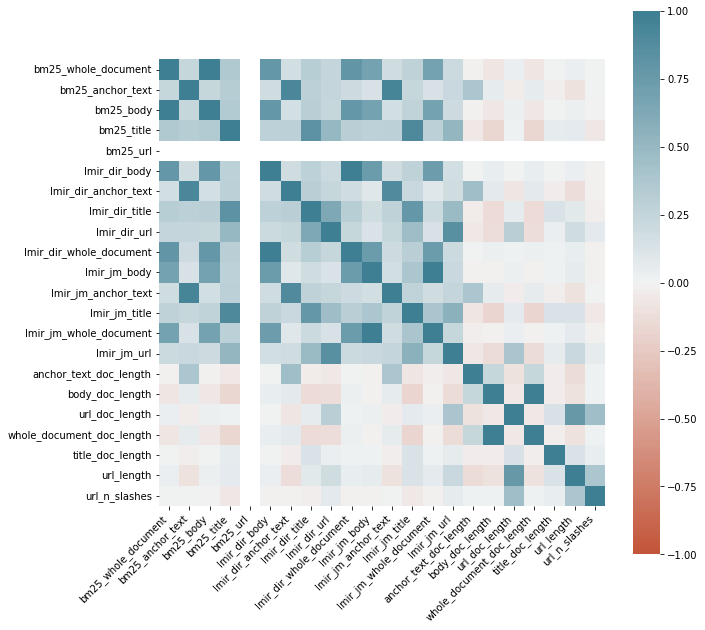

In [16]:
df_corr = df_train[feature_cols].corr()
plot_corr_matrix(df_corr)

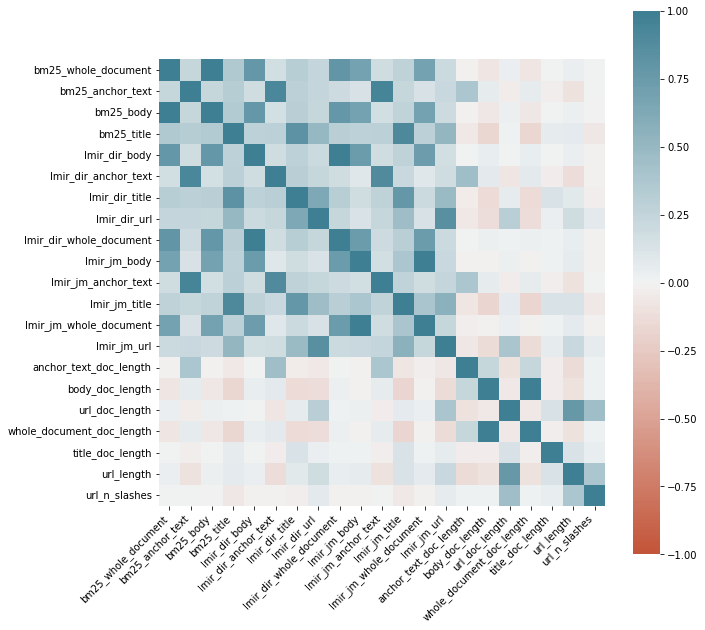

In [17]:
df_corr = df_train[training_cols].corr()
plot_corr_matrix(df_corr)

## Distribution of the independent variables

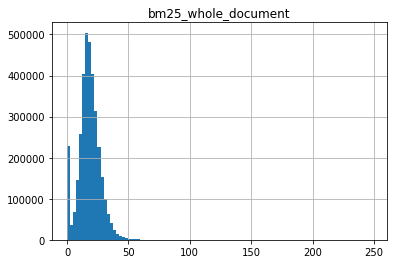

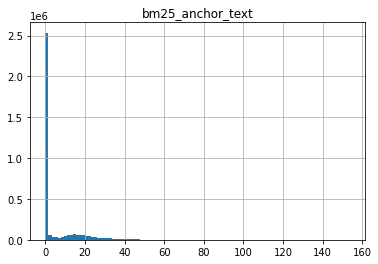

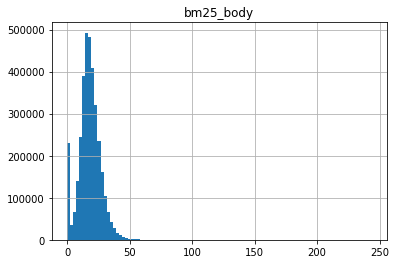

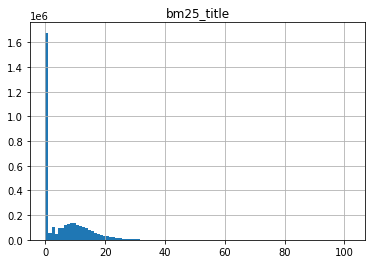

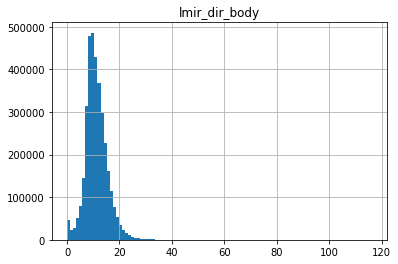

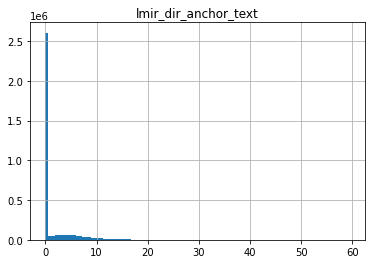

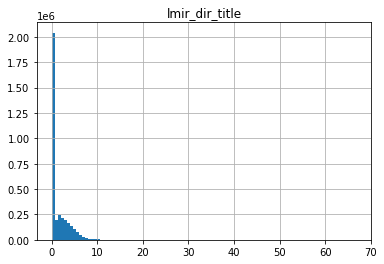

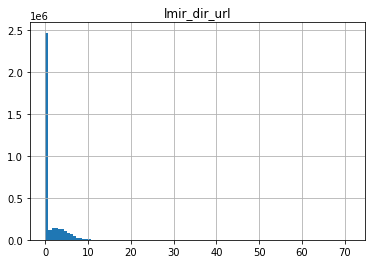

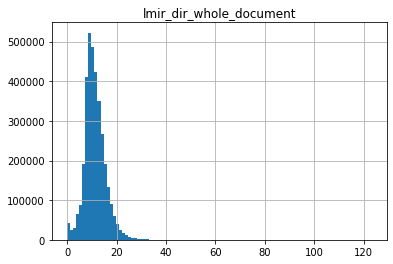

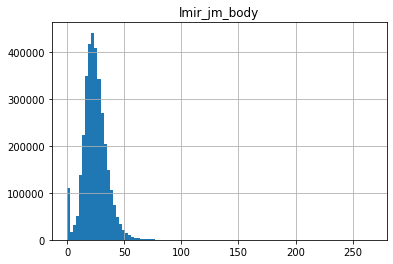

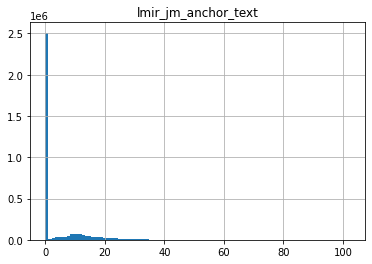

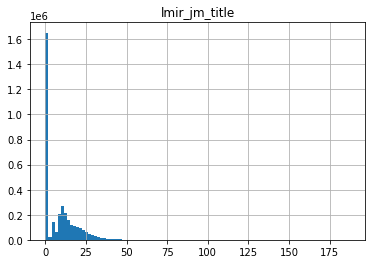

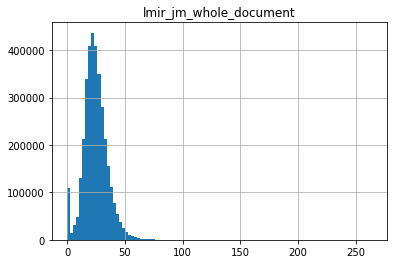

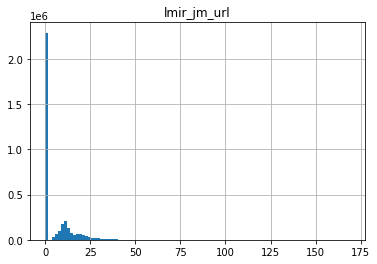

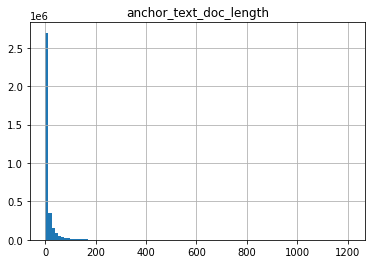

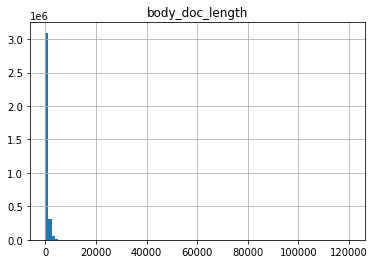

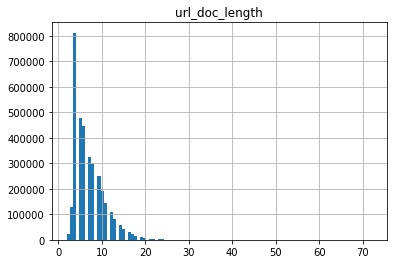

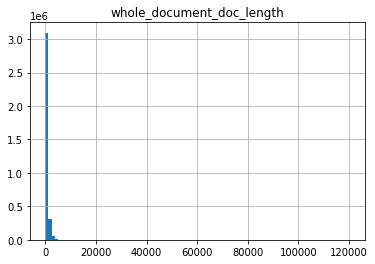

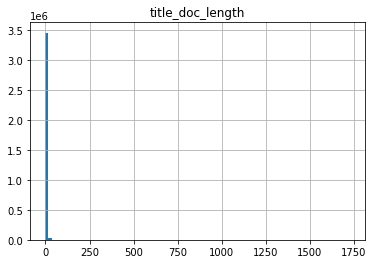

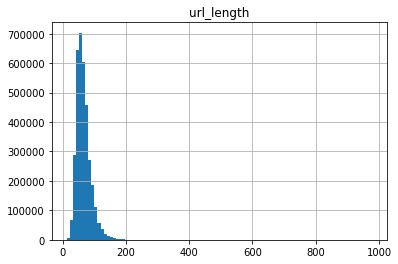

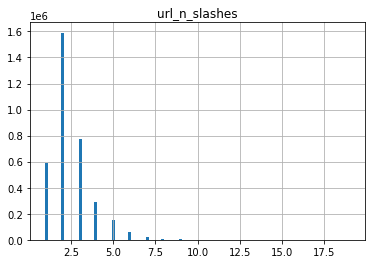

In [18]:
for var in training_cols:
#     ax = sns.boxplot(data=df_train, x='label', y=var)
#     ax.set_title(var)
#     ax.set(title=var, xlabel='relevância', ylabel=None)
#     plt.savefig(f'plots/{var}.png', dpi=400)
    df_train[var].hist(bins=100)
    plt.title(var)
    plt.show();

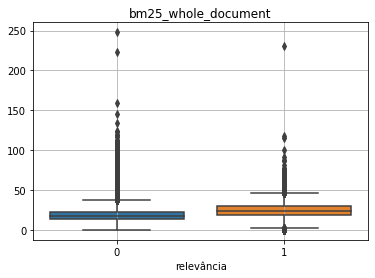

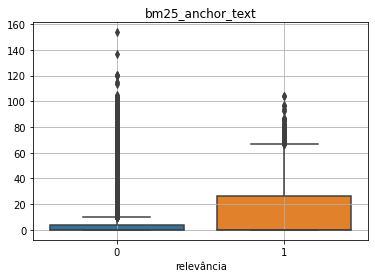

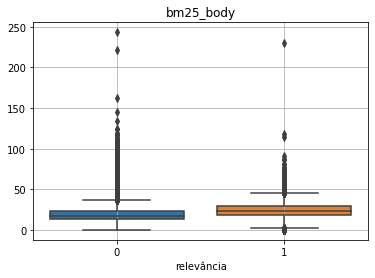

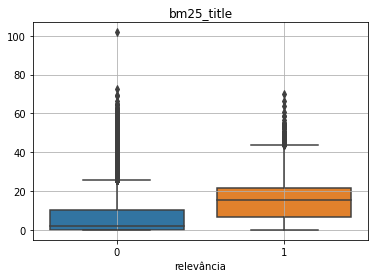

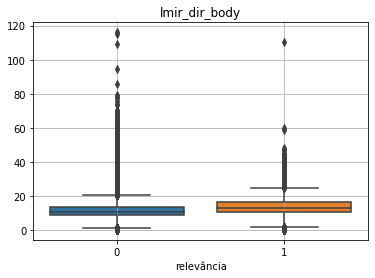

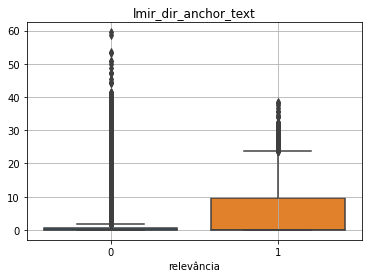

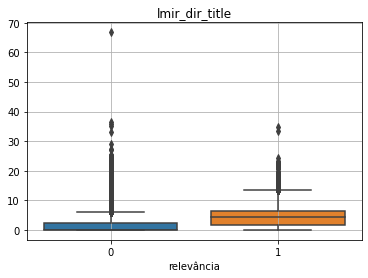

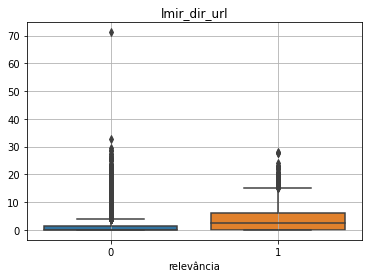

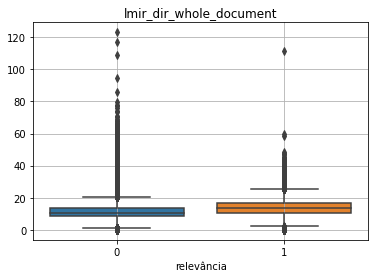

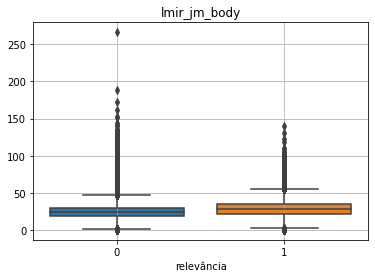

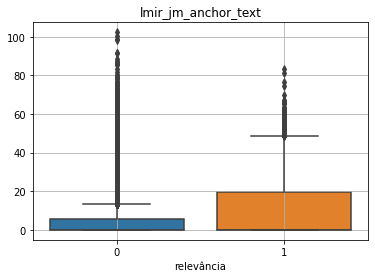

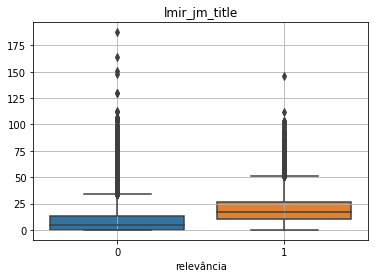

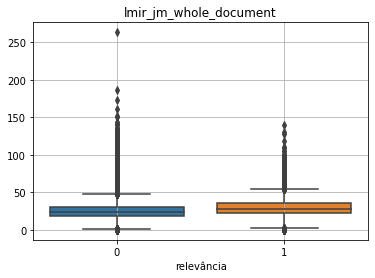

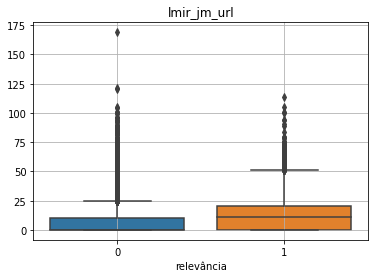

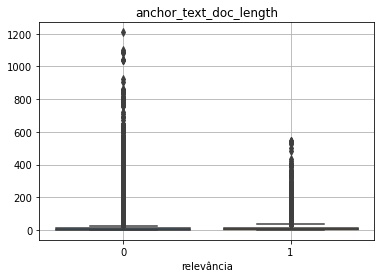

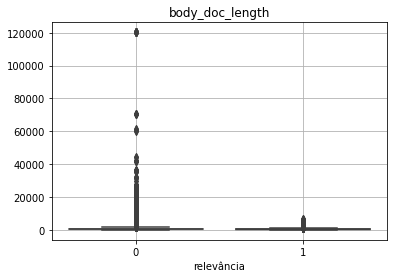

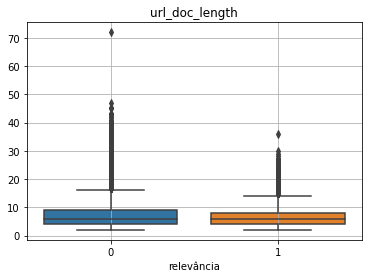

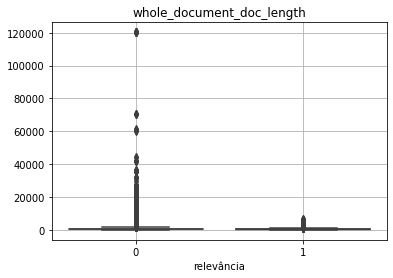

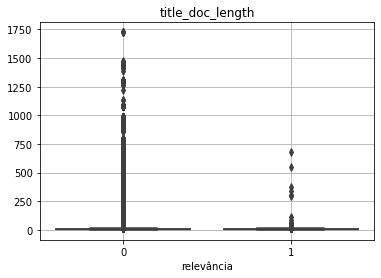

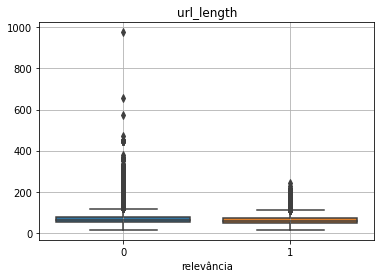

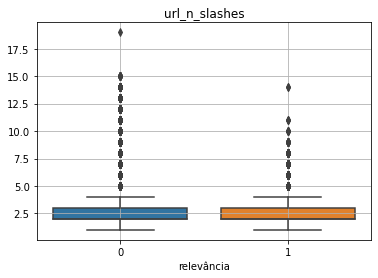

In [19]:
for var in training_cols:
    ax = sns.boxplot(data=df_train, x='label', y=var)
    ax.set_title(var)
    ax.set(title=var, xlabel='relevância', ylabel=None)
    plt.grid()
    plt.savefig(f'plots/{var}.png', dpi=400)
    plt.show();

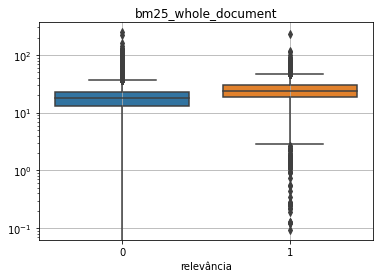

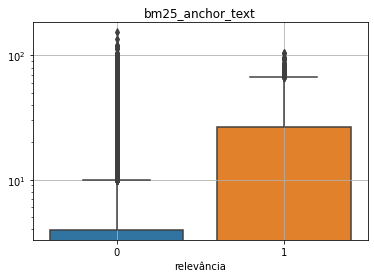

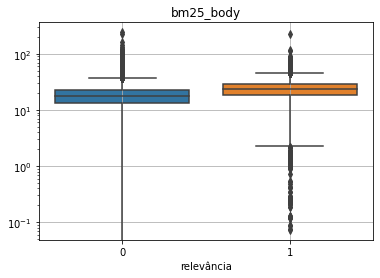

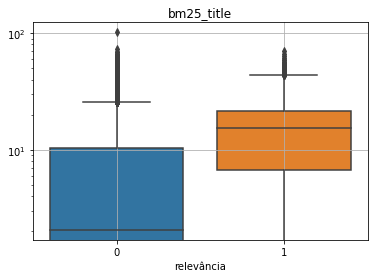

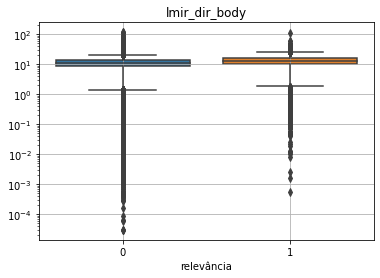

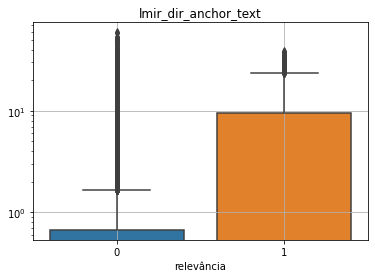

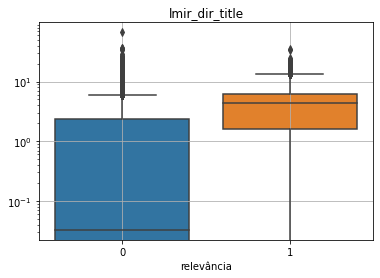

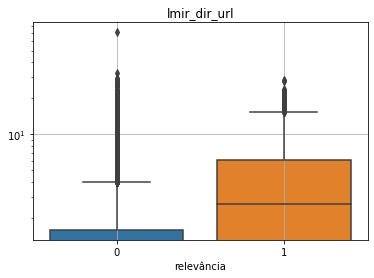

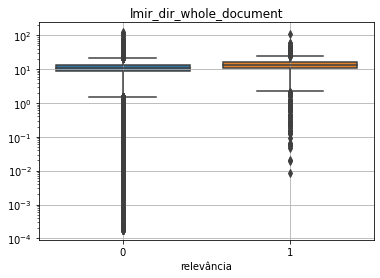

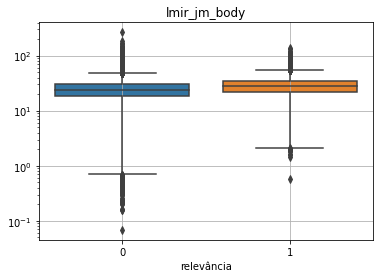

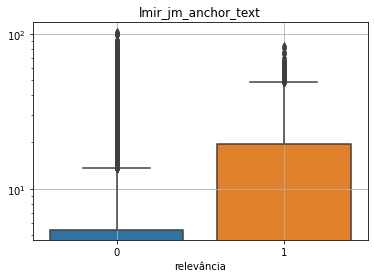

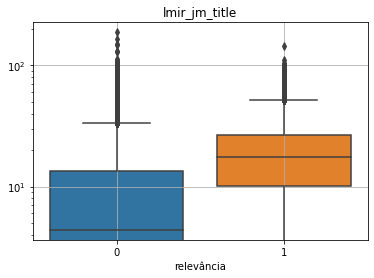

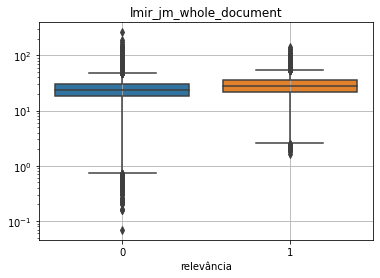

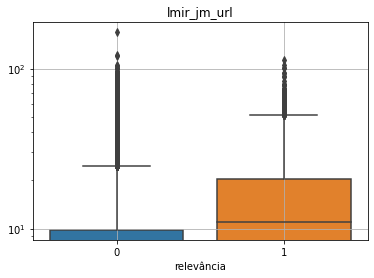

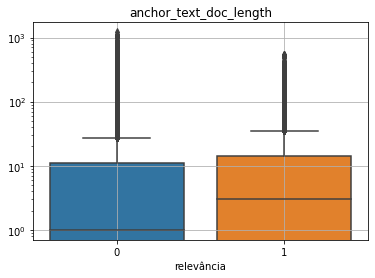

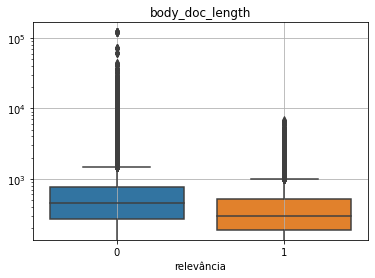

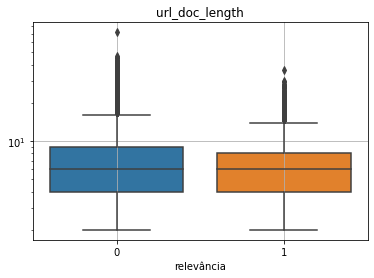

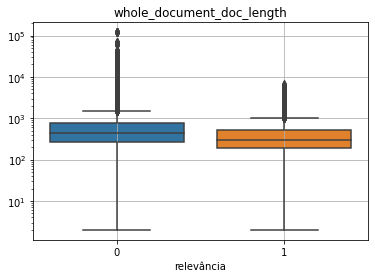

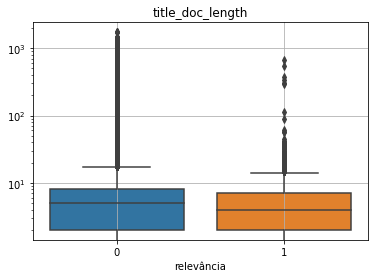

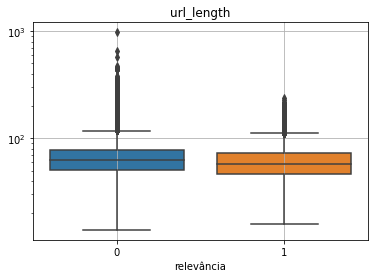

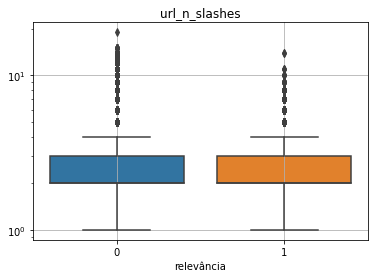

In [20]:
for var in training_cols:
    ax = sns.boxplot(data=df_train, x='label', y=var)
    ax.set_title(var)
    ax.set(title=var, xlabel='relevância', ylabel=None)
    ax.set_yscale('log')
    plt.grid()
    plt.savefig(f'plots/{var}_log.png', dpi=400)
    plt.show();

## Casting some variables to log scale

In [21]:
# vars_to_log = [
#     'anchor_text_doc_length',
#     'body_doc_length',
#     'url_doc_length',
#     'whole_document_doc_length',
#     'title_doc_length',
#     'url_length'
# ]

# for var in vars_to_log:
#     df_train[var] = np.log(df_train[var] + 1)
#     df_eval[var] = np.log(df_eval[var] + 1)

# 2. Model fitting

## Training a logistic model

In [22]:
cols_to_remove = [
    'bm25_url',
    'bm25_whole_document',
    'lmir_dir_whole_document',
    'lmir_jm_whole_document',
    'whole_document_doc_length'
]

training_cols = [col for col in feature_cols if col not in cols_to_remove]

In [23]:
X_train = sm.add_constant(df_train[training_cols])
y_train = df_train[['label']]

logit_mod = sm.Logit(y_train, X_train)
logit_mod = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.037521
         Iterations 10


In [24]:
logit_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:              3493600
Model:                          Logit   Df Residuals:                  3493582
Method:                           MLE   Df Model:                           17
Date:                Mon, 08 Aug 2022   Pseudo R-squ.:                  0.1426
Time:                        17:03:04   Log-Likelihood:            -1.3108e+05
converged:                       True   LL-Null:                   -1.5289e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.8860      0.030   -163.346      0.000      -4.945      -4.827
bm25_anchor_text          -0.0247      0.002    -13.641      0.000      -0.028      -0.021
bm25_body                  0.0571      0.002     29.398      0.000       0.053       0.061
bm25_title                -0.0172      0.003     -6.788      0.000      -0.022      -0.012
lmir_dir_body             -0.0340      0.003     -9.883      0.000      -0.041      -0.027
lmir_dir_anchor_text       0.0881      0.003     26.976      0.000       0.082       0.094
lmir_dir_title             0.1667      0.005     31.432      0.000       0.156       0.177
lmir_dir_url               0.0393      0.006      7.036      0.000       0.028       0.050
lmir_jm_body              -0.0214      0.001    -16.836      0.000      -0.024      -0.019
lmir_jm_anchor_text        0.0171      0.002      7.824      0.000       0.013       0.021
lmir_jm_title              0.0515      0.002     23.858      0.000       0.047       0.056
lmir_jm_url                0.0064      0.002      3.824      0.000       0.003       0.010
anchor_text_doc_length     0.0021      0.000      9.073      0.000       0.002       0.003
body_doc_length           -0.0005   1.73e-05    -29.824      0.000      -0.001      -0.000
url_doc_length            -0.0011      0.004     -0.258      0.796      -0.010       0.007
title_doc_length          -0.1168      0.003    -39.584      0.000      -0.123      -0.111
url_length                -0.0078      0.001    -14.006      0.000      -0.009      -0.007
url_n_slashes             -0.0105      0.007     -1.596      0.110      -0.023       0.002
==========================================================================================
"""

## Evaluation

### ROC Curve, Cutoff and Confusion Matrix

In [25]:
logit_X_eval = sm.add_constant(X_eval[training_cols])
y_probs = logit_mod.predict(logit_X_eval)

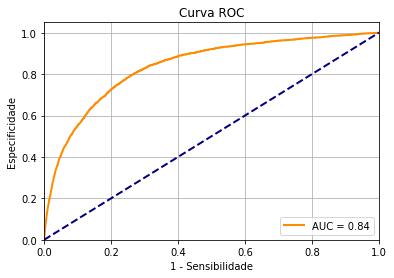

In [26]:
fpr, tpr, threshold = plot_roc_curve(y_eval, y_probs);

In [27]:
# cutoff where tpr and fpr differ the most
cutoff = threshold[(tpr - fpr).argmax()]
y_pred = (y_probs > cutoff).astype(np.int8)

print(f"Classification cutoff : {cutoff}\n")
print(classification_report(y_eval, y_pred))
print(confusion_matrix(y_eval, y_pred, labels=[0, 1]));

Classification cutoff : 0.005848416731381306

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    515372
           1       0.02      0.79      0.04      3928

    accuracy                           0.74    519300
   macro avg       0.51      0.77      0.45    519300
weighted avg       0.99      0.74      0.85    519300

[[382518 132854]
 [   815   3113]]


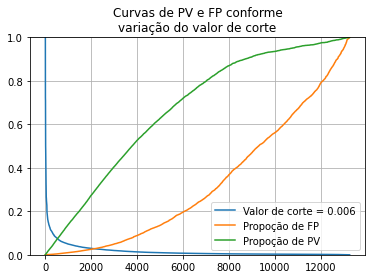

In [28]:
plt.plot(threshold, label=f'Valor de corte = {cutoff:0.3f}')
plt.plot(fpr, label='Propoção de FP')
plt.plot(tpr, label='Propoção de PV')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.title("Curvas de PV e FP conforme\nvariação do valor de corte");

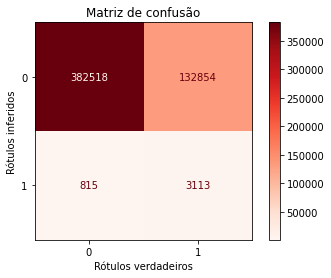

In [29]:
ConfusionMatrixDisplay.from_predictions(y_eval, y_pred, cmap='Reds')
plt.title("Matriz de confusão")
plt.xlabel("Rótulos verdadeiros")
plt.ylabel("Rótulos inferidos");

## XGBoost pointwise

In [30]:
model_params = {
    'n_estimators': 100,
#     'max_depth': 4, 
#     'learning_rate': 1e-2,
# #     'min_child_weight': 10,
# #     'gamma': 1e-1,
    'alpha': 10,
    'verbosity':1, 
    'objective':'binary:logistic',
#     'colsample_bytree': 0.5,
#     'scale_pos_weight': scaling_factor,
    'random_state': 42,
    'early_stopping_rounds': 10,
}
fit_params = {
    'eval_set': [
        (df_eval[training_cols], df_eval.label),
        (df_train[training_cols], df_train.label),
    ],
    'verbose': True
}
model_xgb = xgb.XGBClassifier(**model_params)
model_xgb.fit(df_train[training_cols], df_train.label, **fit_params)

[0]	validation_0-logloss:0.44468	validation_1-logloss:0.44484
[1]	validation_0-logloss:0.30804	validation_1-logloss:0.30810
[2]	validation_0-logloss:0.22245	validation_1-logloss:0.22249
[3]	validation_0-logloss:0.16572	validation_1-logloss:0.16573
[4]	validation_0-logloss:0.12698	validation_1-logloss:0.12691
[5]	validation_0-logloss:0.10003	validation_1-logloss:0.09987
[6]	validation_0-logloss:0.08109	validation_1-logloss:0.08085
[7]	validation_0-logloss:0.06773	validation_1-logloss:0.06737
[8]	validation_0-logloss:0.05825	validation_1-logloss:0.05780
[9]	validation_0-logloss:0.05156	validation_1-logloss:0.05101
[10]	validation_0-logloss:0.04681	validation_1-logloss:0.04618
[11]	validation_0-logloss:0.04349	validation_1-logloss:0.04276
[12]	validation_0-logloss:0.04112	validation_1-logloss:0.04033
[13]	validation_0-logloss:0.03950	validation_1-logloss:0.03861
[14]	validation_0-logloss:0.03836	validation_1-logloss:0.03739
[15]	validation_0-logloss:0.03759	validation_1-logloss:0.03653
[1

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=10, ...)

### Importância das variáveis

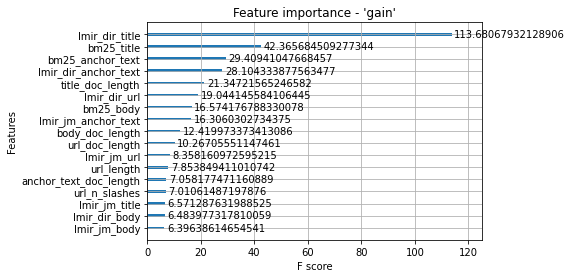

In [31]:
importance_type='gain'
xgb.plot_importance(model_xgb, importance_type=importance_type)
plt.title(f"Feature importance - '{importance_type}'");

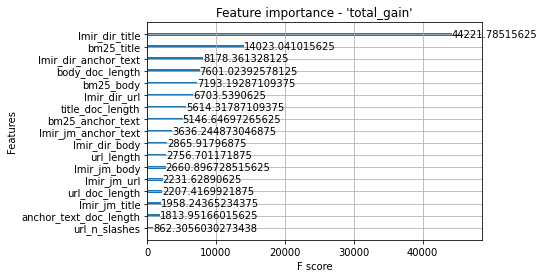

In [32]:
importance_type='total_gain'
xgb.plot_importance(model_xgb, importance_type=importance_type)
plt.title(f"Feature importance - '{importance_type}'");

In [33]:
y_pred = model_xgb.predict(X_eval[training_cols])
y_probs = model_xgb.predict_proba(X_eval[training_cols])[:, 1]

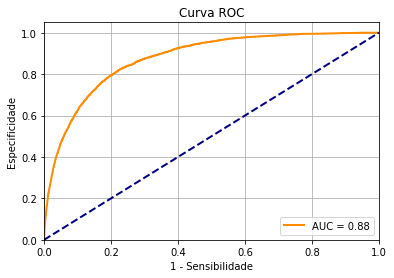

In [34]:
fpr, tpr, threshold = plot_roc_curve(y_eval, y_probs);

In [35]:
# cutoff where tpr and fpr differ the most
cutoff = threshold[(tpr - fpr).argmax()]
y_pred = (y_probs > cutoff).astype(np.int8)

print(f"Classification cutoff : {cutoff}\n")
print(classification_report(y_eval, y_pred))
print(confusion_matrix(y_eval, y_pred, labels=[0, 1]));

Classification cutoff : 0.00581700261682272

              precision    recall  f1-score   support

           0       1.00      0.77      0.87    515372
           1       0.03      0.82      0.05      3928

    accuracy                           0.77    519300
   macro avg       0.51      0.80      0.46    519300
weighted avg       0.99      0.77      0.87    519300

[[398461 116911]
 [   692   3236]]


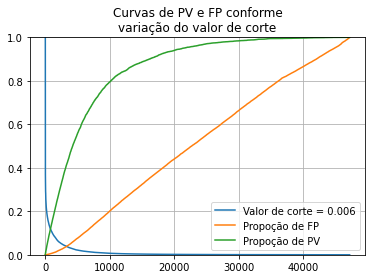

In [36]:
plt.plot(threshold, label=f'Valor de corte = {cutoff:0.3f}')
plt.plot(fpr, label='Propoção de FP')
plt.plot(tpr, label='Propoção de PV')
plt.legend()
plt.ylim(0,1)
plt.grid()
plt.title("Curvas de PV e FP conforme\nvariação do valor de corte");

## XGBoost LambdaMART

In [37]:
group_sizes = df_train.groupby('query_id').size().to_frame('size')['size'].to_numpy()
eval_group_sizes = df_eval.groupby('query_id').size().to_frame('size')['size'].to_numpy()

In [38]:
model_params = {
    'objective':'rank:pairwise',
    'random_state': 42,
    'alpha': 10,
#     'learning_rate': 1e-2,
    'n_estimators': 150,
    'early_stopping_rounds': 10,
}
fit_params = {
    'group': group_sizes,
    'eval_set': [
        (df_eval[training_cols], df_eval.label),
        (df_train[training_cols], df_train.label),
    ],
    'eval_group': [
        eval_group_sizes,
        group_sizes,
    ],
    'eval_metric': 'ndcg@100',
    'verbose': True
}
model_xgb_pairwise = xgb.XGBRanker(**model_params)
model_xgb_pairwise.fit(
    df_train[training_cols],
    df_train.label,
    **fit_params
)

/home/althayr/.cache/pypoetry/virtualenvs/bachelor-thesis-ufrj-2022-ByzaD2JK-py3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-ndcg@100:0.58493	validation_1-ndcg@100:0.59567
[1]	validation_0-ndcg@100:0.58929	validation_1-ndcg@100:0.60376
[2]	validation_0-ndcg@100:0.59205	validation_1-ndcg@100:0.60744
[3]	validation_0-ndcg@100:0.59385	validation_1-ndcg@100:0.60948
[4]	validation_0-ndcg@100:0.59565	validation_1-ndcg@100:0.61175
[5]	validation_0-ndcg@100:0.59680	validation_1-ndcg@100:0.61338
[6]	validation_0-ndcg@100:0.59825	validation_1-ndcg@100:0.61556
[7]	validation_0-ndcg@100:0.59998	validation_1-ndcg@100:0.61770
[8]	validation_0-ndcg@100:0.60184	validation_1-ndcg@100:0.61936
[9]	validation_0-ndcg@100:0.60185	validation_1-ndcg@100:0.62130
[10]	validation_0-ndcg@100:0.60345	validation_1-ndcg@100:0.62346
[11]	validation_0-ndcg@100:0.60372	validation_1-ndcg@100:0.62456
[12]	validation_0-ndcg@100:0.60484	validation_1-ndcg@100:0.62669
[13]	validation_0-ndcg@100:0.60753	validation_1-ndcg@100:0.62841
[14]	validation_0-ndcg@100:0.60811	validation_1-ndcg@100:0.62979
[15]	validation_0-ndcg@100:0.60943	

[126]	validation_0-ndcg@100:0.63713	validation_1-ndcg@100:0.67585
[127]	validation_0-ndcg@100:0.63722	validation_1-ndcg@100:0.67599
[128]	validation_0-ndcg@100:0.63708	validation_1-ndcg@100:0.67605
[129]	validation_0-ndcg@100:0.63706	validation_1-ndcg@100:0.67623
[130]	validation_0-ndcg@100:0.63685	validation_1-ndcg@100:0.67632
[131]	validation_0-ndcg@100:0.63713	validation_1-ndcg@100:0.67649
[132]	validation_0-ndcg@100:0.63718	validation_1-ndcg@100:0.67650
[133]	validation_0-ndcg@100:0.63727	validation_1-ndcg@100:0.67663
[134]	validation_0-ndcg@100:0.63734	validation_1-ndcg@100:0.67681
[135]	validation_0-ndcg@100:0.63738	validation_1-ndcg@100:0.67680
[136]	validation_0-ndcg@100:0.63727	validation_1-ndcg@100:0.67696
[137]	validation_0-ndcg@100:0.63713	validation_1-ndcg@100:0.67728
[138]	validation_0-ndcg@100:0.63724	validation_1-ndcg@100:0.67720
[139]	validation_0-ndcg@100:0.63732	validation_1-ndcg@100:0.67722
[140]	validation_0-ndcg@100:0.63742	validation_1-ndcg@100:0.67726
[141]	vali

XGBRanker(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
          colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
          early_stopping_rounds=10, enable_categorical=False, eval_metric=None,
          gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.300000012, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
          min_child_weight=1, missing=nan, monotone_constraints='()',
          n_estimators=150, n_jobs=0, num_parallel_tree=1, predictor='auto',
          random_state=42, reg_alpha=10, ...)

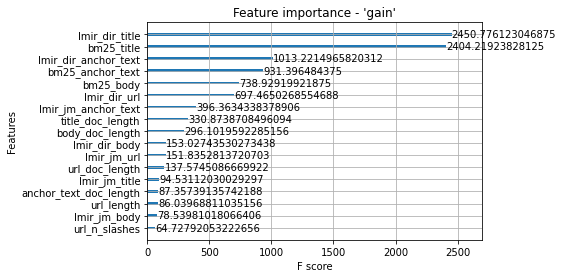

In [39]:
importance_type='gain'
xgb.plot_importance(model_xgb_pairwise, importance_type=importance_type)
plt.title(f"Feature importance - '{importance_type}'");

# Evaluating against msmarco benchmark

In [40]:
def calculate_mrr_logistic(df, score_column=None, feature_columns=None, model=None, n_results=100):
    reciprocal_ranks = []
    for query, grouped_df in tqdm.tqdm(df_eval.groupby('query_id')):
        data = sm.add_constant(grouped_df[feature_columns], has_constant='add')
        preds = model.predict(data)
        grouped_df['_score'] = preds
        ranked_documents = grouped_df.sort_values(by='_score', ascending=False)
        ranked_documents['position'] = list(range(1, ranked_documents.shape[0] + 1))
        ranked_documents = ranked_documents.head(n_results)

        mask_correct = ranked_documents['label'] == 1
        correct_labels = mask_correct.sum()
        if correct_labels == 0:
            ranked_documents[mask_correct]
            reciprocal_ranks.append(0)
        else:
            assert correct_labels == 1
            position = ranked_documents.loc[mask_correct, 'position'].values[0]
            reciprocal_ranks.append(1/position)

    mrr = sum(reciprocal_ranks)/len(reciprocal_ranks)
    #     print(f"Mean Reciprocal Rank: {mrr:,}")
    return mrr

In [41]:
def calculate_mrr(df, score_column=None, feature_columns=None, model=None, n_results=100):
    reciprocal_ranks = []
    for query, grouped_df in df_eval.groupby('query_id'):
        
        
        if model:
            grouped_df['_score'] = model.predict_proba(grouped_df[feature_columns])[:, 1]
            ranked_documents = grouped_df.sort_values(by='_score', ascending=False)
        else:
            ranked_documents = grouped_df.sort_values(by=score_column, ascending=False)
        ranked_documents['position'] = list(range(1, ranked_documents.shape[0] + 1))
        ranked_documents = ranked_documents.head(n_results)

        mask_correct = ranked_documents['label'] == 1
        correct_labels = mask_correct.sum()
        if correct_labels == 0:
            ranked_documents[mask_correct]
            reciprocal_ranks.append(0)
        else:
            assert correct_labels == 1
            position = ranked_documents.loc[mask_correct, 'position'].values[0]
            reciprocal_ranks.append(1/position)

    mrr = sum(reciprocal_ranks)/len(reciprocal_ranks)
#     print(f"Mean Reciprocal Rank: {mrr:,}")
    return mrr

def calculate_ranked_model(df, feature_columns, model, n_results=100):
    reciprocal_ranks = []
    for query, grouped_df in tqdm.tqdm(df.groupby('query_id')):
        if model:
            grouped_df['_score'] = model.predict(grouped_df[feature_columns])
            ranked_documents = grouped_df.sort_values(by='_score', ascending=False)
        else:
            ranked_documents = grouped_df.sort_values(by=score_column, ascending=False)
        ranked_documents['position'] = list(range(1, ranked_documents.shape[0] + 1))
        ranked_documents = ranked_documents.head(n_results)

        mask_correct = ranked_documents['label'] == 1
        correct_labels = mask_correct.sum()
        if correct_labels == 0:
            ranked_documents[mask_correct]
            reciprocal_ranks.append(0)
        else:
            assert correct_labels == 1
            position = ranked_documents.loc[mask_correct, 'position'].values[0]
            reciprocal_ranks.append(1/position)

    mrr = sum(reciprocal_ranks)/len(reciprocal_ranks)
#     print(f"Mean Reciprocal Rank: {mrr:,}")
    return mrr

### Baseline

In [42]:
fields = ['anchor_text', 'url', 'title', 'body', 'whole_document']
similarities = ['bm25', 'lmir_dir', 'lmir_jm']
for similarity in similarities:
    sim_fields = []
    for field in fields:
        similarity_field = f'{similarity}_{field}'
        mrr = calculate_mrr(df_eval, score_column=similarity_field, n_results=10)
        print(f"{similarity_field:<20} : {mrr}")
        sim_fields.append(similarity_field)
    
    similarity_field = f'{similarity}_max'
    df_eval[similarity_field] = df_eval[sim_fields].max(axis=1)
    mrr = calculate_mrr(df_eval, score_column=similarity_field, n_results=10)
    print(f"{similarity_field:<20} : {mrr}")

bm25_anchor_text     : 0.1293940408180732
bm25_url             : 0.1233149630607748
bm25_title           : 0.21584749311496898
bm25_body            : 0.24025901778645847
bm25_whole_document  : 0.25223423472990175
bm25_max             : 0.22059854688393157
lmir_dir_anchor_text : 0.11659093896240055
lmir_dir_url         : 0.1233149630607748
lmir_dir_title       : 0.19454531282954218
lmir_dir_body        : 0.18902842348827387
lmir_dir_whole_document : 0.2050434192548582
lmir_dir_max         : 0.21018755406392678
lmir_jm_anchor_text  : 0.12306447323778345
lmir_jm_url          : 0.1233149630607748
lmir_jm_title        : 0.19840070118810793
lmir_jm_body         : 0.19680973165953014
lmir_jm_whole_document : 0.21041641831647678
lmir_jm_max          : 0.2276954783453916


### Modelos

In [43]:
classifier_name = 'logistic'
classifier = logit_mod

n = 100
mrr = calculate_mrr_logistic(df_eval, feature_columns=training_cols, model=classifier, n_results=n)
print(f"{classifier_name:<20} @ {n} : {mrr}")

n = 10
mrr = calculate_mrr_logistic(df_eval, feature_columns=training_cols, model=classifier, n_results=n)
print(f"{classifier_name:<20} @ {n} : {mrr}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5193/5193 [00:12<00:00, 417.50it/s]


logistic             @ 100 : 0.22568039595140377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5193/5193 [00:12<00:00, 416.41it/s]

logistic             @ 10 : 0.21300331031700212


In [44]:
classifier_name = 'pointwise'
classifier = model_xgb

n = 100
mrr = calculate_mrr(df_eval, feature_columns=training_cols, model=classifier, n_results=n)
print(f"{classifier_name:<20} @ {n} : {mrr}")

n = 10
mrr = calculate_mrr(df_eval, feature_columns=training_cols, model=classifier, n_results=n)
print(f"{classifier_name:<20} @ {n} : {mrr}")

pointwise            @ 100 : 0.24473988002035454
pointwise            @ 10 : 0.232316778691707


### Pairwise loss - rank aware models

In [45]:
classifier_name = 'xgboost pairwise'
classifier = model_xgb_pairwise

n = 100
mrr = calculate_ranked_model(df_eval, training_cols, classifier, n_results=n)
print(f"{classifier_name:<20} @ {n} : {mrr}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5193/5193 [00:13<00:00, 396.85it/s]

xgboost pairwise     @ 100 : 0.29614199543441283
